# UBBR

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [2]:
import pickle

class HeatmapDataset(Dataset):
    """My dataset."""

    def __init__(self, pickle_path, transform=None):
        super(HeatmapDataset, self).__init__()
        self.pickle_path = pickle_path
        self.transform = transform
        
        # load
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
            self.boxes_data = torch.tensor(data['boxes'])
            self.heatmap_data = torch.tensor(data['heatmaps'])
            
        assert len(self.heatmap_data)==len(self.boxes_data), "num_heatmap != num_box"

    def __len__(self):
        return len(self.heatmap_data)

    def __getitem__(self, idx):
        heatmap = self.heatmap_data[idx]
        bboxes = self.boxes_data[idx]
        
        if self.transform:
            heatmap = self.transform(heatmap).unsqueeze(0)

        return heatmap, bboxes

def myCollate(batch):
    img_list = []
    box_list = []
    for img, box in batch:
        img_list.append(img)
        box_list.append(box)
    return torch.stack(img_list), torch.stack(box_list)

In [334]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
# from RoIAlign.roi_align import RoIAlign      # RoIAlign module
# from RoIAlign.roi_align import CropAndResizeFunction # crop_and_resize module
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

def get_rois(images, featuremaps, bboxes):
    # calc bbox ratio
    ratio_y = featuremaps.shape[2]/images.shape[2]
    ratio_x = featuremaps.shape[3]/images.shape[3]
    bboxes_scaled = bboxes.clone()#.detach()

    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

    # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
    bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
    bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [7,7])
    return crops

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class BoxMaker(nn.Module):
    def __init__(self):
        super(BoxMaker, self).__init__()
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        
        # backbone layer
        self.backbone = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1)),#, dilation=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1)),#, dilation=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 256, kernel_size=(3,3), stride=(1, 1)),#, dilation=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256, 512, kernel_size=(3,3), stride=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 512 x 24 x 24
        )
                
        # fc layer
        self.fc = nn.Sequential(
            avg_pool, # n x 512 x 1 x 1
            flatten, # n x 512
            nn.Linear(512, 256),
            nn.Linear(256, 64),
            nn.Linear(64, 4),
#             nn.Sigmoid()
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        
    def forward(self, images):
        """Extract feature vectors from input images."""
        # CNN backbone
        featuremaps = self.backbone(images)
        boxs = self.fc(featuremaps) 
        return boxs


In [338]:
from torchsummary import summary
model = BoxMaker()
model.to(model.device)

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             320
       BatchNorm2d-2         [-1, 32, 222, 222]              64
              ReLU-3         [-1, 32, 222, 222]               0
         MaxPool2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 109, 109]          18,496
       BatchNorm2d-6         [-1, 64, 109, 109]             128
              ReLU-7         [-1, 64, 109, 109]               0
         MaxPool2d-8           [-1, 64, 54, 54]               0
            Conv2d-9          [-1, 256, 52, 52]         147,712
      BatchNorm2d-10          [-1, 256, 52, 52]             512
             ReLU-11          [-1, 256, 52, 52]               0
        MaxPool2d-12          [-1, 256, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [100]:
pickle_path = 'heatmap.pickle'
pickle_val_path = 'heatmap_val.pickle'

my_dataset = HeatmapDataset(pickle_path)
my_dataset_val = HeatmapDataset(pickle_val_path)


my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=16, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)
my_loader_val = torch.utils.data.DataLoader(my_dataset_val, batch_size=16, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)


dataloaders = {
    'train': my_loader,
    'val': my_loader_val
}
dataset_sizes = {
    'train': len(my_dataset),
    'val': len(my_dataset_val)
}
# i,b = next(iter(my_loader))
# i.shape, b.shape

In [101]:
dataset_sizes

{'train': 1599, 'val': 1428}

In [102]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    global loss_list_train, loss_list_val
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for idx, (inputs, boxes_gt) in enumerate(dataloaders[phase]):
                inputs = inputs.to(model.device)
                boxes_gt = boxes_gt.squeeze().to(model.device) # shape맞춰야함

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    boxes_pred = model(inputs)
                    loss = criterion(boxes_pred, boxes_gt)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if(phase=='train'): loss_list_train.append(epoch_loss)
            else: loss_list_val.append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [103]:
# model.load_state_dict(torch.load('torch_models/heatmap.pth'))

In [104]:
from torch.optim import lr_scheduler
import time 
import copy
def criterion(box_pred, box_gt):
    """
    box - N x 4, cx,cy,w,h (normalized like Yolo data)
    """
    loss = (box_pred-box_gt).pow(2)
    loss2 = loss[:,:2]*500 + loss[:, 2:]
    return loss2.sum()

In [336]:
loss_list_train = []
loss_list_val = []
# Observe that only parameters of final layer are being optimized as
# optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [339]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 433.8466
val Loss: 505.2824
Epoch 1/99
----------
train Loss: 433.7337
val Loss: 506.7966
Epoch 2/99
----------
train Loss: 433.8124
val Loss: 504.5028
Epoch 3/99
----------
train Loss: 433.8731
val Loss: 511.6416
Epoch 4/99
----------
train Loss: 433.7801
val Loss: 510.0243
Epoch 5/99
----------
train Loss: 433.8599
val Loss: 507.9478
Epoch 6/99
----------
train Loss: 433.7264
val Loss: 508.3831
Epoch 7/99
----------
train Loss: 433.7827
val Loss: 511.0778
Epoch 8/99
----------
train Loss: 433.7420
val Loss: 509.8519
Epoch 9/99
----------
train Loss: 433.7838
val Loss: 509.3770
Epoch 10/99
----------
train Loss: 433.7838
val Loss: 503.7123
Epoch 11/99
----------
train Loss: 433.8259
val Loss: 506.8681
Epoch 12/99
----------
train Loss: 433.8264
val Loss: 508.7987
Epoch 13/99
----------
train Loss: 433.7945
val Loss: 510.6938
Epoch 14/99
----------
train Loss: 433.8029
val Loss: 502.9293
Epoch 15/99
----------
train Loss: 433.7681
val Loss: 511.5749
Ep

In [ ]:
2.5~2.8

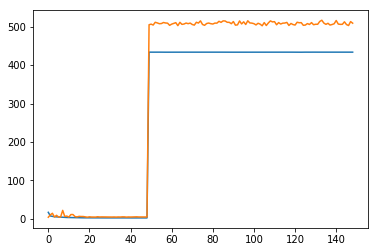

In [340]:
plt.plot(loss_list_train)
plt.plot(loss_list_val)
plt.show()

In [333]:
model.eval()
torch.save(model.state_dict(), 'torch_models/heatmap-dilate2.pth')

---
# Test

In [265]:
import matplotlib.patches as patches

my_loader_test = torch.utils.data.DataLoader(my_dataset_val, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)

loader = iter(my_loader_test)
model.eval()
def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

[ 34  37 104 172]


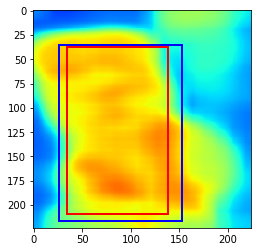

In [332]:
heatmap, box = loader.next()
box = box.cpu().numpy() 
box = cvt_yolobox(box[0], heatmap.shape[-2:])
x1,y1,w1,h1 = box[0]
box_adj = model(heatmap.cuda()).detach().cpu().numpy()
box_adj = cvt_yolobox(box_adj, heatmap.shape[-2:])
x2,y2,w2,h2 = box_adj[0]
print(box_adj[0])

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
imgplot = ax.imshow(heatmap[0][0].cpu(), cmap='jet')
imgplot.set_clim(0,1)

# Create a Rectangle patch
rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
rect_pred = patches.Rectangle((x2,y2),w2,h2, linewidth=2,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect_pred)

plt.show()